**Here we try crossing statistics with simulated light curves using Alex's method. For simplicity we first consider 2 images only. Also I changed some parameters in the light curve simulation.Here we have set: nobs=40, fluc=4, t1=60, which are same as what Alex set.** 


In [1]:
%reset -f

In [45]:
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np
import corner
#plt.rcParams['figure.figsize'] = [12, 8]

No. of data points in r,g,i,z bands= 40 40 40 40 respectively

Since we know the underlying model, we can calculate the Chi^2 in this simulation for the actual model. This might be handy later.

Chi^2 original: r-band= 36.29992796617137 g-band= 39.15126035027544 i-band= 42.70024545731749 z-band= 28.002741201895518


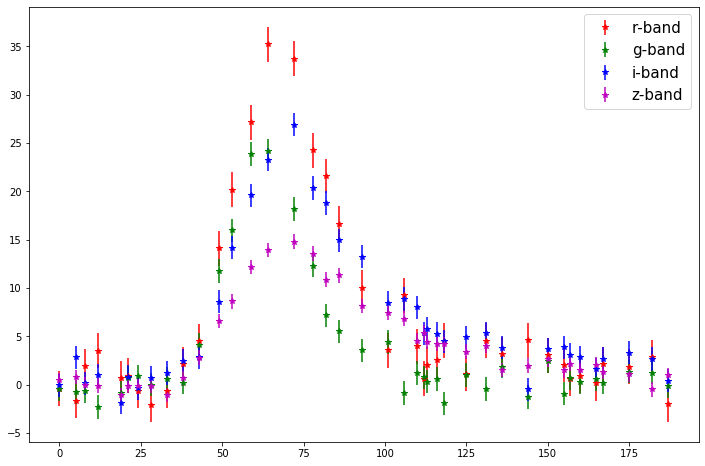

In [46]:
inp_path='Alex_simulated_data/'
bands=['lsstg','lsstr','lssti','lsstz']
fileN='Alex_sim_nobs_40_fluc4_t1_60_mu_1.8_3.0_dt_1.1_13.2'

fileNr=inp_path+fileN+bands[1]+'.txt';#print(fileNr)
fileNg=inp_path+fileN+bands[0]+'.txt';#print(fileNg)
fileNi=inp_path+fileN+bands[2]+'.txt';#print(fileNi)
fileNz=inp_path+fileN+bands[3]+'.txt';#print(fileNz)

tr,fr,sigfr,fr1,fr2=np.loadtxt(fileNr,usecols=[0,1,2,3,4], unpack=True)
tg,fg,sigfg,fg1,fg2=np.loadtxt(fileNg,usecols=[0,1,2,3,4], unpack=True)
ti,fi,sigfi,fi1,fi2=np.loadtxt(fileNi,usecols=[0,1,2,3,4], unpack=True)
tz,fz,sigfz,fz1,fz2=np.loadtxt(fileNz,usecols=[0,1,2,3,4], unpack=True)

print("No. of data points in r,g,i,z bands=",len(tr), len(tz),len(ti),len(tz),"respectively\n")

t_mins=np.array([np.amin(tr), np.amin(tg), np.amin(ti), np.amin(tz)])
t_maxs=np.array([np.amax(tr), np.amax(tg), np.amax(ti), np.amax(tz)])
t_min=np.amin(t_mins)-1e-5; t_max=np.amax(t_maxs)+1e-5;

#we substract a fixed time, it should not have any effect on the pystan results
tr=tr-t_min; tg=tg-t_min; ti=ti-t_min; tz=tz-t_min;

t_max=t_max-t_min; t_min=0.0;

clr=['r','g','b','k']
plt.rcParams['figure.figsize'] = [12, 8]
plt.errorbar(tr,fr,yerr=sigfr,fmt="r*",label=r"r-band")
plt.errorbar(tg,fg,yerr=sigfg,fmt="g*",label=r"g-band")
plt.errorbar(ti,fi,yerr=sigfi,fmt="b*",label=r"i-band")
plt.errorbar(tz,fz,yerr=sigfz,fmt="m*",label=r"z-band")
plt.legend(loc=0,fontsize=15)


fro=fr1+fr2;fgo=fg1+fg2;fio=fi1+fi2;fzo=fz1+fz2
chisqro=np.sum((fro-fr)**2/sigfr**2); chisqgo=np.sum((fgo-fg)**2/sigfg**2);
chisqio=np.sum((fio-fi)**2/sigfi**2);chisqzo=np.sum((fzo-fz)**2/sigfz**2);
print("Since we know the underlying model, we can calculate the Chi^2 in this simulation for the actual model. This might be handy later.")
print("\nChi^2 original: r-band=",chisqro,"g-band=",chisqgo,"i-band=",chisqio,"z-band=",chisqzo)


The system has two images: $\mu=1.8,3.0$ and $dt=1.1,13.2$. SInce below we mainly model the earlier image with the intrinsic flux model, we expect to find $\mu=3.0/1.8=1.667$ and $dt=12.1$.

In [47]:
mu_des=3.0/1.8; dt_des=12.1;

In [48]:
#template 2: t^n exp(-t/tk); no stretch, crossing statistics upto 2nd order

#tmax=np.amax(tr)



def mod2(x,t0,n,xk,s,c0,c1,c2,c3,c4):
    x=x-t0;
    x=x-s*x;
    x[x<1e-15]=1e-15
    fx=(x**n)*np.exp(-x/xk)
    xmax=np.amax(x)
    xs=x/xmax
    #print("len=",len(xs[xs<0.5]))
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs-1)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs+1.0));
    return fx_mod

#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('nr', 2.0, True, 1.0,4.0), ('tkr', 10.0, True, 1.0,40.0),('sr', 0.01,True, 0.0,0.99));
p.add_many(('ng', 2.0, True, 1.0,4.0), ('tkg', 10.0, True, 1.0,40.0),('sg', 0.01,True, 0.0,0.99))#, ;

p.add_many(('mu1', 0.58, True, 0.4,2.0),('dt1',1.0, True,0,30.0) ,('t0',10.0, True,0.0,60.0));
#p.add('dt2', value=0.50, min=0, max=10.0)
p.add_many(('c0r', 1.0, True,None,None),('c1r', 0.1, True, None,None),('c2r', 0.1, True, None,None),
           ('c3r', 0, False, -10,10) ,('c4r', 0.0,False, None,None))

p.add_many(('c0g', 1.0, True,None,None),('c1g', 0.1, True, None,None),('c2g', 0.1, True, None,None),
           ('c3g', 0, False, -10,10) ,('c4g', 0.0,False, None,None))

p.add_many(('nni', 2.0, True, 1.0,4.0), ('tki', 10.0, True, 1.0,40.0),('si', 0.01,True, 0.0,0.99));
p.add_many(('c0i', 1.0, True,None,None),('c1i', 0.1, True, None,None),('c2i', 0.1, True, None,None),
          ('c3i', 0, False, -10,10))

p.add_many(('nz', 2.0, True, 1.0,4.0), ('tkz', 10.0, True, 1.0,40.0),('sz', 0.01,True, 0.0,0.99));
p.add_many(('c0z', 1.0, True,None,None),('c1z', 0.1, True, None,None),('c2z', 0.1,True, None,None))

def residual(p):
    v = p.valuesdict()
    
    B1=(mod2(tr,v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])
            +v['mu1']*mod2(tr-v['dt1'],v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])-fr)/sigfr;
        
    B2=(mod2(tg,v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])
            +v['mu1']*mod2(tg-v['dt1'],v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])-fg)/sigfg;
    
    B3=(mod2(ti,v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],0,0)
            +v['mu1']*mod2(ti-v['dt1'],v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],0,0)-fi)/sigfi;
    
    B4=(mod2(tz,v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],0,0)
            +v['mu1']*mod2(tz-v['dt1'],v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],0,0)-fz)/sigfz;
    
    return np.concatenate((B1,B2,B3,B4))


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res02 = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=10000, steps=200000, thin=3, nwalkers=150,
                     params=p, is_weighted=False,seed=20145)
lmfit.report_fit(res02.params)

100%|██████████| 200000/200000 [2:30:05<00:00, 22.21it/s]  


The chain is shorter than 50 times the integrated autocorrelation time for 28 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4000;
tau: [18049.35226205 23158.16507871 24059.57205161 21921.50992401
 19802.95859667 19340.1322396  14513.82585308 15067.82107891
  6818.34739343 23653.42804641 23685.16407211 23660.54928612
 17987.37849059 21600.238293   18369.644343   16389.42300888
 20046.68034951 22803.43514884 23929.1146347  24442.29073961
 23818.63024991 15421.68951302 20940.89993361 21937.64592203
 21532.68227434 21205.67334388 20077.76789738 12847.80609486]
[[Variables]]
    nr:         1.51030003 +/- 0.24630812 (16.31%) (init = 2)
    tkr:        7.17719951 +/- 3.73114586 (51.99%) (init = 10)
    sr:         0.47503494 +/- 0.31074033 (65.41%) (init = 0.01)
    ng:         1.45159515 +/- 0.49391165 (34.03%) (init = 2)
    tkg:        5.93477093 +/- 1.79035665 (30.17%) (init = 10)
    sg:         0.18717587 +/- 0.19716746 (105.34%) (init = 0.01)
    mu1:    

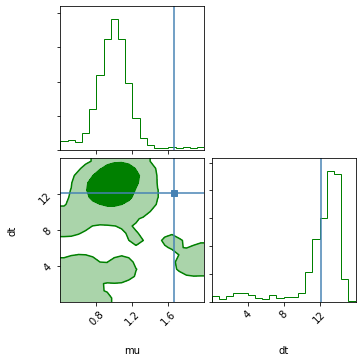

In [49]:
import corner
#print(res2.params.valuesdict().values())
emcee_plot = corner.corner(res02.flatchain[['mu1','dt1']], labels=['mu','dt'],color='g', smooth=1,
                        levels=(0.68,0.95),plot_density=0, fill_contours=1, plot_datapoints=0,
                           truths=list([mu_des,dt_des]))

The results are completely off the expectation.


Maximum likelihood Estimation
-----------------------------


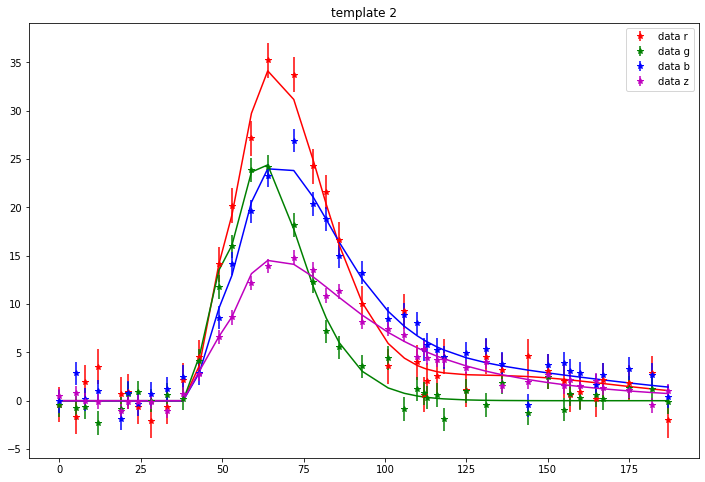

Maximum liklihood: mu= 0.8812883948758432 dt= 12.255895729793764
Chi^2 r= 36.708292570338806 Chi^2 g= 33.75317266343144 Chi^2 i= 46.0402062411805 Chi^2 z= 27.126746880868154
Chi^2 original: r= 36.29992796617137 g= 39.15126035027544 Chi^2 i= 42.70024545731749 Chi^2 z= 28.002741201895518


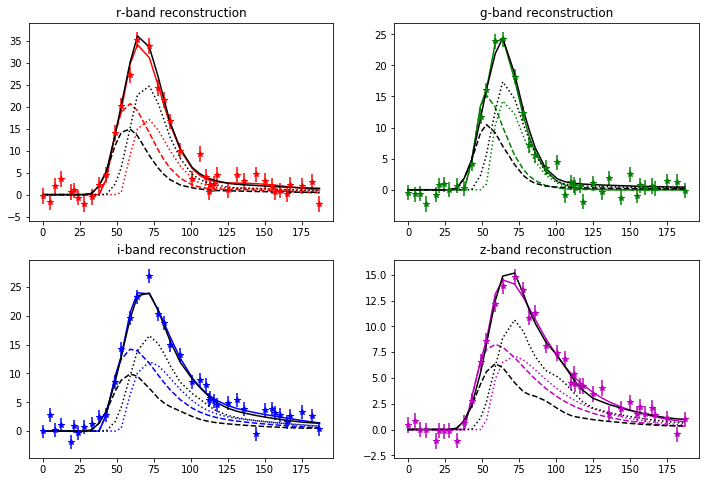

In [61]:
def plot_func2(res):
    highest_prob = np.argmax(res.lnprob)
    hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
    mle_soln = res.chain[hp_loc]
    #print(mle_soln.shape)
    #sys.exit()
    #for i, par in enumerate(p):
    #p[par].value = mle_soln[i]
    #print(mle_soln[i])
    print("\nMaximum likelihood Estimation")
    print('-----------------------------')
    c4rm=0; srm=0; c3rm=0;#mum=1.5;
    c4gm=0; sgm=0; c3gm=0;
    c2rm=c2gm=c2im=c2zm=0;
    [nrm,tkrm,srm,ngm,tkgm,sgm,mum,dtm,t0m,c0rm,c1rm,c2rm,c0gm,c1gm,c2gm,
     nim,tkim,sim,c0im,c1im,c2im,nzm,tkzm,szm,c0zm,c1zm,c2zm,lnm]=mle_soln;
    #print(nrm,tkrm,ngm,tkgm,mum,dtm,t0m,c0rm,c1rm,c0gm,c1gm,c2gm,lnm)
    #print("Maximum liklihood: mu=",mum, "dt=",dtm)
    #sys.exit()
    #print(p)
    Ps1r=mod2(tr,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,c4rm)
    Ps2r=mum*mod2(tr-dtm,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,c4rm)
    Psr=Ps1r+Ps2r
    fro=fr1+fr2
    
    Ps1g=mod2(tg,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,c4gm)
    Ps2g=mum*mod2(tg-dtm,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,c4gm)
    Psg=Ps1g+Ps2g
    fgo=fg1+fg2
    
    Ps1i=mod2(ti,t0m,nim,tkim,sim,c0im,c1im,c2im,0,0)
    Ps2i=mum*mod2(ti-dtm,t0m,nim,tkim,sim,c0im,c1im,c2im,0,0)
    Psi=Ps1i+Ps2i
    fio=fi1+fi2
    
    Ps1z=mod2(tz,t0m,nzm,tkzm,szm,c0zm,c1zm,c2zm,0,0)
    Ps2z=mum*mod2(tz-dtm,t0m,nzm,tkzm,szm,c0zm,c1zm,c2zm,0,0)
    Psz=Ps1z+Ps2z
    fzo=fz1+fz2
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.title(r'template 2')
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    #plt.plot(tr, Ps1r, c="r",ls="--")
    #plt.plot(tr, Ps2r, c="r",ls="dotted")
    
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    
    plt.errorbar(ti,fi,yerr=sigfi,fmt='b*',label=r"data b") #data
    plt.plot(ti, Psi, c="b")
    
    plt.errorbar(tz,fz,yerr=sigfz,fmt='m*',label=r"data z") #data
    plt.plot(tz, Psz, c="m")
 
    plt.legend(loc=0)
    plt.show()
    chisqr=np.sum((Psr-fr)**2/sigfr**2); chisqg=np.sum((Psg-fg)**2/sigfg**2);  
    chisqi=np.sum((Psi-fi)**2/sigfi**2); chisqz=np.sum((Psz-fz)**2/sigfz**2);
    
    chisqro=np.sum((fro-fr)**2/sigfr**2); chisqgo=np.sum((fgo-fg)**2/sigfg**2);
    chisqio=np.sum((fio-fi)**2/sigfi**2);chisqzo=np.sum((fzo-fz)**2/sigfz**2);
    #chisq_o=np.sum((ft_total-y)**2/sigft**2)
    print("Maximum liklihood: mu=",mum, "dt=",dtm)
    print("Chi^2 r=",chisqr,"Chi^2 g=",chisqg,"Chi^2 i=",chisqi,"Chi^2 z=",chisqz)
    print("Chi^2 original: r=",chisqro,"g=",chisqgo,"Chi^2 i=",chisqio,"Chi^2 z=",chisqzo)
    plt.show()
    
    plt.subplot(2, 2, 1)
    plt.title(r'r-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    plt.plot(tr, Ps1r,c="r",ls="--")
    plt.plot(tr, Ps2r,c="r",ls="dotted")
    plt.plot(tr, fro, c="k")
    plt.plot(tr, fr1,c="k",ls="--")
    plt.plot(tr, fr2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 2)
    plt.title(r'g-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    plt.plot(tg, Ps1g,c="g",ls="--")
    plt.plot(tg, Ps2g,c="g",ls="dotted")
    
    plt.plot(tg, fgo, c="k")
    plt.plot(tg, fg1,c="k",ls="--")
    plt.plot(tg, fg2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 3)
    plt.title(r'i-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    t=ti
    plt.errorbar(t,fi,yerr=sigfi,fmt='b*',label=r"data i") #data
    plt.plot(t, Psi, c="b")
    plt.plot(t, Ps1i,c="b",ls="--")
    plt.plot(t, Ps2i,c="b",ls="dotted")
    
    plt.plot(t, fio, c="k")
    plt.plot(t, fi1,c="k",ls="--")
    plt.plot(t, fi2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 4)
    plt.title(r'z-band reconstruction')
    t=tz
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(t,fz,yerr=sigfz,fmt='m*',label=r"data z") #data
    plt.plot(t, Psz, c="m")
    plt.plot(t, Ps1z,c="m",ls="--")
    plt.plot(t, Ps2z,c="m",ls="dotted")
    
    plt.plot(t, fzo, c="k")
    plt.plot(t, fz1,c="k",ls="--")
    plt.plot(t, fz2,c="k",ls="dotted")
    
    plt.show()
    
plot_func2(res02)

Template 2 does not work well. Lets try template 1 below.

In [51]:
def mod(x,t0,n,xk,s,c0,c1,c2,c3,c4):    
    mean=n;sig=xk;
    x=x-t0;
    x=x-s*x;
    x[x<1e-15]=1e-15
    fx=(1.0/(sig*np.sqrt(2.0*np.pi)*x))*np.exp(-0.5*(np.log(x)-mean)**2/(sig*sig))
    xmax=np.amax(x)
    xs=x/xmax
    #print("len=",len(xs[xs<0.5]))
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs-1)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs+1.0));
    return fx_mod

#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('mu1', 1.0, True, 0.4,2.0),('dt1',5.0, True,0,25.0) ,('t0',1.0, True,0.0,60.0));

p.add_many(('nr', 1.0, True, 0.1,10.0), ('tkr', 0.1, True, 0.0,3.0),('sr', 0.01,True, 0.0,0.99));
p.add_many(('c0r', 1.0, True,None,None),('c1r', 0.1, True, None,None),('c2r', 0.1, True, None,None),
           ('c3r', 0.0, False, None,None) ,('c4r', 0.0,False, None,None))

p.add_many(('ng', 1.0, True, 0.1,10.0), ('tkg', 0.1, True, 0.0,3.0),('sg', 0.01,True, 0.0,0.99))#, ;
p.add_many(('c0g', 1.0, True,None,None),('c1g', 0.1, True, None,None),('c2g', 0.1, True, None,None),
           ('c3g', 0.0,False, None,None) ,('c4g', 0.0,False, None,None))

p.add_many(('nni', 1.0, True, 0.0,10.0), ('tki', 0.1, True, 0.0,3.0),('si', 0.01,True, 0.0,0.99));
p.add_many(('c0i', 1.0, True,None,None),('c1i', 0.1, True, None,None),('c2i', 0.1, True, None,None),
          ('c3i', 0, False, None,None))

p.add_many(('nz', 1.0, True, 0.1,10.0), ('tkz', 0.10, True, 0.0,3.0),('sz', 0.01,True, 0.0,0.99));
p.add_many(('c0z', 1.0, True,None,None),('c1z', 0.1, True, None,None),('c2z', 0.1,True, None,None),
          ('c3z', 0, False, None,None))

def residual(p):
    v = p.valuesdict()
    
    B1=(mod(tr,v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])
            +v['mu1']*mod(tr-v['dt1'],v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])-fr)/sigfr;
        
    B2=(mod(tg,v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])
            +v['mu1']*mod(tg-v['dt1'],v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])-fg)/sigfr;
    
    B3=(mod(ti,v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],v['c3i'],0)
            +v['mu1']*mod(ti-v['dt1'],v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],v['c3i'],0)-fi)/sigfi;
    
    B4=(mod(tz,v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],v['c3z'],0)
            +v['mu1']*mod(tz-v['dt1'],v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],v['c3z'],0)-fz)/sigfz;
    
    return np.concatenate((B1,B2,B3,B4))


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res01 = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=10000, steps=200000, thin=3, nwalkers=150,
                     params=p, is_weighted=False,seed=20145)
lmfit.report_fit(res01.params)

100%|██████████| 200000/200000 [2:45:27<00:00, 20.15it/s]  


The chain is shorter than 50 times the integrated autocorrelation time for 28 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4000;
tau: [16227.46910121 11703.1043728  10243.31748949 18426.38208934
 11044.29566608 17601.97961576 24944.74876418 24775.04453675
 24470.47984322 12329.56621033 12822.21295571 13743.52982297
 18028.68209831 16836.13023968 18150.59687457 12857.38975908
 11993.86265997 18244.3042727  26287.50732436 26060.33616559
 25633.55939528 12471.78470547 10159.28919086 12452.9352462
 18818.59300583 18895.53752087 18533.28336077 17085.2297062 ]
[[Variables]]
    mu1:        1.03548731 +/- 0.24253336 (23.42%) (init = 1)
    dt1:        13.3549942 +/- 0.91241825 (6.83%) (init = 5)
    t0:         33.7959774 +/- 3.36574993 (9.96%) (init = 1)
    nr:         3.14025894 +/- 1.02945700 (32.78%) (init = 1)
    tkr:        0.51212531 +/- 0.08559878 (16.71%) (init = 0.1)
    sr:         0.44056426 +/- 0.38095826 (86.47%) (init = 0.01)
    c0r:        219

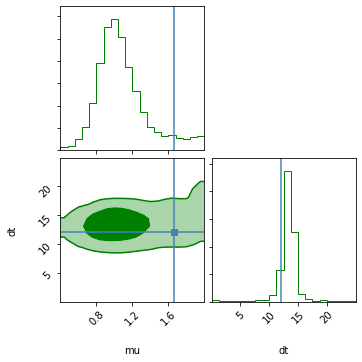

In [52]:
import corner
#print(res2.params.valuesdict().values())
emcee_plot = corner.corner(res01.flatchain[['mu1','dt1']], labels=['mu','dt'],color='g', smooth=1,
                        levels=(0.68,0.95),plot_density=0, fill_contours=1, plot_datapoints=0,
                           truths=list([mu_des,dt_des]))


Maximum likelihood Estimation
-----------------------------


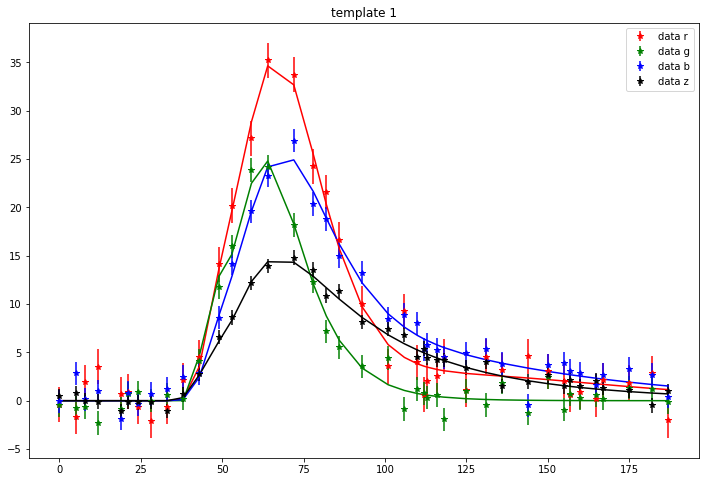

Maximum liklihood: mu= 1.0219980831394755 dt= 13.30050600238817

Chi^2 r= 34.10490203698308 Chi^2 g= 34.07022029379837 Chi^2 i= 42.203400918854186 Chi^2 z= 24.949310605733334
Chi^2 original: r= 36.29992796617137 g= 39.15126035027544 Chi^2 i= 42.70024545731749 Chi^2 z= 28.002741201895518


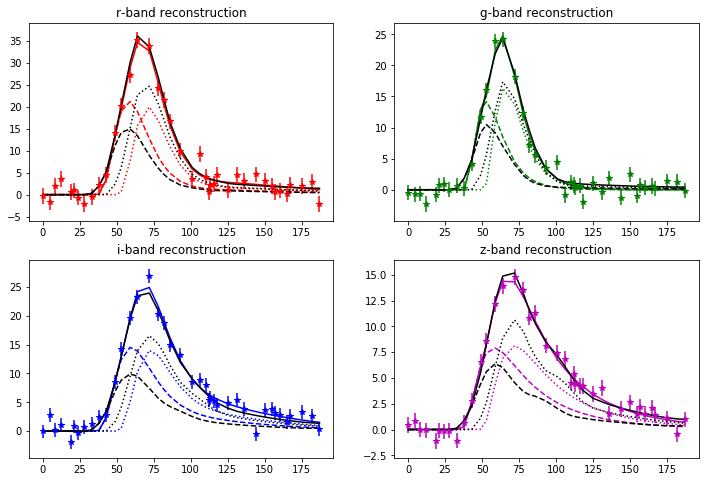

In [60]:
def plot_func(res):
    highest_prob = np.argmax(res.lnprob)
    hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
    mle_soln = res.chain[hp_loc]
    #print(mle_soln.shape)
    #sys.exit()
    #for i, par in enumerate(p):
    #p[par].value = mle_soln[i]
    #print(mle_soln[i])
    print("\nMaximum likelihood Estimation")
    print('-----------------------------')
    #print(len(mle_soln))
    c4rm=0; srm=0; c3rm=0;#mum=1.5;
    c4gm=0; sgm=0; c3gm=0;
    c2rm=c2gm=c2im=c2zm=0;
    [mum,dtm,t0m,
     nrm,tkrm,srm,c0rm,c1rm,c2rm,#c3rm,
     ngm,tkgm,sgm,c0gm,c1gm,c2gm,#c3gm,
     nim,tkim,sim,c0im,c1im,c2im,
     nzm,tkzm,szm,c0zm,c1zm,c2zm,
     lnm]=mle_soln;
    
    #print(mle_soln)
    #print("g-band: ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm=",ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm)
    #mum,dtm=1.4/2.4,15.0
    #print("Maximum liklihood: mu=",mum, "dt=",dtm)
    #sys.exit()
    #print(p)
    Ps1r=mod(tr,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,0)
    Ps2r=mum*mod(tr-dtm,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,0)
    Psr=Ps1r+Ps2r
    fro=fr1+fr2
    
    Ps1g=mod(tg,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,0)
    Ps2g=mum*mod(tg-dtm,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,0)
    Psg=Ps1g+Ps2g
    fgo=fg1+fg2
    
    Ps1i=mod(ti,t0m,nim,tkim,sim,c0im,c1im,c2im,0,0)
    Ps2i=mum*mod(ti-dtm,t0m,nim,tkim,sim,c0im,c1im,c2im,0,0)
    Psi=Ps1i+Ps2i
    fio=fi1+fi2
    
    Ps1z=mod(tz,t0m,nzm,tkzm,szm,c0zm,c1zm,c2zm,0,0)
    Ps2z=mum*mod(tz-dtm,t0m,nzm,tkzm,szm,c0zm,c1zm,c2zm,0,0)
    Psz=Ps1z+Ps2z
    fzo=fz1+fz2
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.title(r'template 1')
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    #plt.plot(tr, Ps1r, c="r",ls="--")
    #plt.plot(tr, Ps2r, c="r",ls="dotted")
    
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    
    plt.errorbar(ti,fi,yerr=sigfi,fmt='b*',label=r"data b") #data
    plt.plot(ti, Psi, c="b")
    
    plt.errorbar(tz,fz,yerr=sigfz,fmt='k*',label=r"data z") #data
    plt.plot(tz, Psz, c="k")
 
    plt.legend(loc=0)
    plt.show()
    chisqr=np.sum((Psr-fr)**2/sigfr**2); chisqg=np.sum((Psg-fg)**2/sigfg**2);  
    chisqi=np.sum((Psi-fi)**2/sigfi**2); chisqz=np.sum((Psz-fz)**2/sigfz**2);
    c4gm
    chisqro=np.sum((fro-fr)**2/sigfr**2); chisqgo=np.sum((fgo-fg)**2/sigfg**2);
    chisqio=np.sum((fio-fi)**2/sigfi**2);chisqzo=np.sum((fzo-fz)**2/sigfz**2);
    #chisq_o=np.sum((ft_total-y)**2/sigft**2)
    print("Maximum liklihood: mu=",mum, "dt=",dtm)
    print("\nChi^2 r=",chisqr,"Chi^2 g=",chisqg,"Chi^2 i=",chisqi,"Chi^2 z=",chisqz)
    print("Chi^2 original: r=",chisqro,"g=",chisqgo,"Chi^2 i=",chisqio,"Chi^2 z=",chisqzo)
    plt.show()
    
    plt.subplot(2, 2, 1)
    plt.title(r'r-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    plt.plot(tr, Ps1r,c="r",ls="--")
    plt.plot(tr, Ps2r,c="r",ls="dotted")
    plt.plot(tr, fro, c="k")
    plt.plot(tr, fr1,c="k",ls="--")
    plt.plot(tr, fr2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 2)
    plt.title(r'g-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    plt.plot(tg, Ps1g,c="g",ls="--")
    plt.plot(tg, Ps2g,c="g",ls="dotted")
    
    plt.plot(tg, fgo, c="k")
    plt.plot(tg, fg1,c="k",ls="--")
    plt.plot(tg, fg2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 3)
    plt.title(r'i-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    t=ti
    plt.errorbar(t,fi,yerr=sigfi,fmt='b*',label=r"data i") #data
    plt.plot(t, Psi, c="b")
    plt.plot(t, Ps1i,c="b",ls="--")
    plt.plot(t, Ps2i,c="b",ls="dotted")
    
    plt.plot(t, fio, c="k")
    plt.plot(t, fi1,c="k",ls="--")
    plt.plot(t, fi2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 4)
    plt.title(r'z-band reconstruction')
    t=tz
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(t,fz,yerr=sigfz,fmt='m*',label=r"data z") #data
    plt.plot(t, Psz, c="m")
    plt.plot(t, Ps1z,c="m",ls="--")
    plt.plot(t, Ps2z,c="m",ls="dotted")
    
    plt.plot(t, fzo, c="k")
    plt.plot(t, fz1,c="k",ls="--")
    plt.plot(t, fz2,c="k",ls="dotted")
    
    plt.show()
    
plot_func(res01)

Again the reconstruction is bad.

Lets try the same with pystan. 

In [54]:
model = """
functions{
    vector crossing_model(vector xx, real xm, real t0, int Nx, real mean,real sig, real s, real c0,real c1,real c2)//,real c3,real c4)
    {
        
        vector[Nx] fx;
        vector[Nx] fx_mod;
        real xs;
        real x;
        int j;

      // /* j=1;
      //  while(xx[j]<=t0)
      //  {
      //      fx[j]=0;
      //      fx_mod[j]=0;
      //      j=j+1;
      //  
      //  }*/

        
        for (i in 1:Nx)
        {
            x=xx[i]-t0; xs=x/(xm-t0);
            if(x<=0)
            {
                fx[i]=0;
                fx_mod[i]=0;
            }
            else
            {
                fx[i]=(1.0/(sig*sqrt(2.0*pi())*x))*exp(-0.5*(log(x)-mean)*(log(x)-mean)/(sig*sig));
                fx_mod[i]=fx[i]*(c0+c1*xs+c2*(2.0*xs*xs -1.0));
                //+c3*(4.0*xs*xs*xs-3.0*xs)+c4*(8.0*xs*xs*xs*xs-8.0*xs*xs + 1.0));
            }
        }
        
        
    
        return fx_mod;
    
    }


    
    //==============================================================================
}

data{

    int<lower=0> ni;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;
    int<lower=0> Nz;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;
    real trm;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;
    real tgm;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;
    real tim;
    
    vector[Nz] tz;
    vector[Nz] yz;
    vector[Nz] yz_error;
    real tzm;
    
    real dt_max;
}
parameters {

    real<lower=0.0, upper=10.0> meanr; real<lower=0.0, upper=3.0> sigr; real<lower=0.0,upper=0.99> sr;
    real<lower=0.0, upper=10.0> meang; real<lower=0.0, upper=3.0> sigg; real<lower=0.0,upper=0.99> sg;
    real<lower=0.0, upper=10.0> meani; real<lower=0.0, upper=3.0> sigi; real<lower=0.0,upper=0.99> si;
    real<lower=0.0, upper=10.0> meanz; real<lower=0.0, upper=3.0> sigz; real<lower=0.0,upper=0.99> sz;
    
    real c0r; real c1r; real c2r; //real c3r; real c4r;
    real c0g; real c1g; real c2g; //real c3g; real c4g;
    real c0i; real c1i; real c2i; //real c3i; real c4i;
    real c0z; real c1z; real c2z; //real c3z; real c4z;
    
    real<lower=0.4, upper=2.0> mu;//actually measuring amplitudes relative 
    real <lower=0, upper=dt_max> dt;
    
    real<lower=0.0, upper=60.0> t0;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;
    vector[Nz] dumz;

    //dum needs
    dumr=crossing_model(tr, trm, t0,Nr,meanr,sigr,sr, c0r,c1r,c2r);
    dumr=dumr+mu*crossing_model(tr-dt, trm, t0,Nr,meanr,sigr,sr, c0r,c1r,c2r);//adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=crossing_model(tg, tgm, t0, Ng,meang,sigg,sg, c0g,c1g,c2g);
    dumg=dumg+mu*crossing_model(tg-dt, tgm, t0, Ng,meang,sigg,sg, c0g,c1g,c2g);//adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=crossing_model(ti, tim, t0, Ni,meani,sigi,si, c0i,c1i,c2i);
    dumi=dumi+mu*crossing_model(ti-dt, tim, t0,Ni,meani,sigi,si,c0i,c1i,c2i);//adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);
    
    dumz=crossing_model(tz,tzm, t0, Nz,meanz,sigz,sz, c0z,c1z,c2z);
    dumz=dumz+mu*crossing_model(tz-dt, tzm, t0,Nz,meanz,sigz,sz, c0z,c1z,c2z);//adding the 2nd image
    target+=normal_lpdf(yz|dumz,yz_error);
      

}
"""
NI=2

dt_min=0.0; dt_max=25.0

trm=np.amax(tr); tgm= np.amax(tg); tim= np.amax(ti); tzm=np.amax(tz);

data = {'ni':NI,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti), 'Nz': len(tz),
        'tr': tr, 'yr': fr, 'yr_error':sigfr, 'trm':trm,
        'tg': tg, 'yg': fg, 'yg_error':sigfg, 'tgm':tgm,
        'ti': ti, 'yi': fi, 'yi_error':sigfi, 'tim':tim,
        'tz': tz, 'yz': fz, 'yz_error':sigfz, 'tzm':tzm,
        'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit3 = sm.sampling(data=data, iter=100000, chains=6, warmup=8000, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_defcc2deb7153bd2c6285e320c18c638 NOW.


Inference for Stan model: anon_model_defcc2deb7153bd2c6285e320c18c638.
6 chains, each with iter=100000; warmup=8000; thin=3; 
post-warmup draws per chain=30667, total post-warmup draws=184002.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
meanr   3.52    0.07   0.46   2.12   3.42   3.65   3.81   4.04     48   1.12
sigr    0.42     0.1    0.2   0.01   0.39   0.47   0.54   0.69      4   2.59
sr      0.49  3.5e-3   0.29   0.02   0.24   0.49   0.74   0.96   6793    1.0
meang   3.06    0.12   0.43    2.2   2.76   3.07   3.38   3.83     14    1.2
sigg    0.38    0.04   0.11   0.17   0.31   0.39   0.46   0.59      6   1.44
sg       0.5  3.5e-3   0.29   0.03   0.25    0.5   0.75   0.97   6877    1.0
meani   3.79    0.11   0.44    2.1   3.71   3.87    4.0   4.26     16   1.37
sigi    0.53    0.04   0.13    0.3   0.44   0.52    0.6   0.83     10   1.31
si       0.5  3.4e-3   0.29   0.03   0.25    0.5   0.75   0.96   7033    1.0
meanz   3.22     0.2   0.69   1.92  

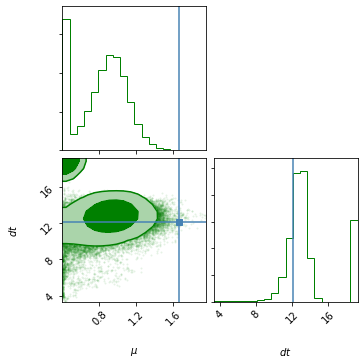

In [58]:
def contour(fit):
    #print("Expected: mu=",mu_expec, "dt=",dt_expec)
    la = fit.extract(permuted=True)
    mu_pos = np.vstack((la['mu'])).T
    dt_pos = np.vstack((la['dt'])).T
    #print(mu_pos.shape)
    #P_pos=np.vstack((la['P'])).T
    postsamples = np.vstack((mu_pos, dt_pos)).T
    #print(postsamples.shape)
    fig = corner.corner(postsamples, labels=[r"$\mu$", r"$dt$"],color='g', smooth=1,
                        levels=(0.68,0.95),plot_density=0, fill_contours=1, plot_datapoints=1,
                           truths=list([mu_des,dt_des]))
    #return fig
    
contour(fit3)

Again the desired result is far away. But the contour is different from what we got above using emcee!


Below we try the same template 1 but with 4th order crossing statistics. 

In [56]:
model = """
functions{
    vector crossing_model(vector xx, real xm, real t0, int Nx, real mean,real sig, real s, 
    real c0,real c1,real c2,real c3,real c4)
    {
        
        vector[Nx] fx;
        vector[Nx] fx_mod;
        real xs;
        real x;
        int j;

      // /* j=1;
      //  while(xx[j]<=t0)
      //  {
      //      fx[j]=0;
      //      fx_mod[j]=0;
      //      j=j+1;
      //  
      //  }*/

        
        for (i in 1:Nx)
        {
            x=xx[i]-t0; xs=x/(xm-t0);
            if(x<=0)
            {
                fx[i]=0;
                fx_mod[i]=0;
            }
            else
            {
                fx[i]=(1.0/(sig*sqrt(2.0*pi())*x))*exp(-0.5*(log(x)-mean)*(log(x)-mean)/(sig*sig));
                fx_mod[i]=fx[i]*(c0+c1*xs+c2*(2.0*xs*xs -1.0)
                +c3*(4.0*xs*xs*xs-3.0*xs)+c4*(8.0*xs*xs*xs*xs-8.0*xs*xs + 1.0));
            }
        }
        
        
    
        return fx_mod;
    
    }


    
    //==============================================================================
}

data{

    int<lower=0> ni;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;
    int<lower=0> Nz;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;
    real trm;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;
    real tgm;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;
    real tim;
    
    vector[Nz] tz;
    vector[Nz] yz;
    vector[Nz] yz_error;
    real tzm;
    
    real dt_max;
}
parameters {

    real<lower=0.0, upper=10.0> meanr; real<lower=0.0, upper=3.0> sigr; real<lower=0.0,upper=0.99> sr;
    real<lower=0.0, upper=10.0> meang; real<lower=0.0, upper=3.0> sigg; real<lower=0.0,upper=0.99> sg;
    real<lower=0.0, upper=10.0> meani; real<lower=0.0, upper=3.0> sigi; real<lower=0.0,upper=0.99> si;
    real<lower=0.0, upper=10.0> meanz; real<lower=0.0, upper=3.0> sigz; real<lower=0.0,upper=0.99> sz;
    
    real c0r; real c1r; real c2r; real c3r; real c4r;
    real c0g; real c1g; real c2g; real c3g; real c4g;
    real c0i; real c1i; real c2i; real c3i; real c4i;
    real c0z; real c1z; real c2z; real c3z; real c4z;
    
    real<lower=0.4, upper=2.5> mu;//actually measuring amplitudes relative 
    real <lower=0, upper=dt_max> dt;
    
    real<lower=0.0, upper=60.0> t0;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;
    vector[Nz] dumz;

    //dum needs
    dumr=crossing_model(tr, trm, t0,Nr,meanr,sigr,sr, c0r,c1r,c2r,c3r,c4r);
    dumr=dumr+mu*crossing_model(tr-dt, trm, t0,Nr,meanr,sigr,sr, c0r,c1r,c2r,c3r,c4r);//adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=crossing_model(tg, tgm, t0, Ng,meang,sigg,sg, c0g,c1g,c2g,c3g,c4g);
    dumg=dumg+mu*crossing_model(tg-dt, tgm, t0, Ng,meang,sigg,sg, c0g,c1g,c2g,c3g,c4g);//adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=crossing_model(ti, tim, t0, Ni,meani,sigi,si, c0i,c1i,c2i,c3i,c4i);
    dumi=dumi+mu*crossing_model(ti-dt, tim, t0,Ni,meani,sigi,si,c0i,c1i,c2i,c3i,c4i);//adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);
    
    dumz=crossing_model(tz,tzm, t0, Nz,meanz,sigz,sz, c0z,c1z,c2z,c3z,c4z);
    dumz=dumz+mu*crossing_model(tz-dt, tzm, t0,Nz,meanz,sigz,sz, c0z,c1z,c2z,c3z,c4z);//adding the 2nd image
    target+=normal_lpdf(yz|dumz,yz_error);
      

}
"""
NI=2

dt_min=0.0; dt_max=50.0

trm=np.amax(tr); tgm= np.amax(tg); tim= np.amax(ti); tzm=np.amax(tz);

data = {'ni':NI,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti), 'Nz': len(tz),
        'tr': tr, 'yr': fr, 'yr_error':sigfr, 'trm':trm,
        'tg': tg, 'yg': fg, 'yg_error':sigfg, 'tgm':tgm,
        'ti': ti, 'yi': fi, 'yi_error':sigfi, 'tim':tim,
        'tz': tz, 'yz': fz, 'yz_error':sigfz, 'tzm':tzm,
        'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit4 = sm.sampling(data=data, iter=150000, chains=6, warmup=10000, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6cb57f85bbb9c5ea6068fe2403b97eaa NOW.


Inference for Stan model: anon_model_6cb57f85bbb9c5ea6068fe2403b97eaa.
6 chains, each with iter=150000; warmup=10000; thin=3; 
post-warmup draws per chain=46667, total post-warmup draws=280002.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
meanr    2.85    0.41   0.81   1.48   2.05   3.06   3.45   3.99      4   2.23
sigr     0.63    0.06   0.15   0.38   0.53   0.63   0.71   0.91      7   1.54
sr       0.51    0.02   0.29   0.03   0.26   0.51   0.76   0.97    266   1.02
meang    2.35    0.21   0.45   1.52   2.01   2.34   2.66   3.24      4   2.16
sigg      0.5    0.06   0.12   0.28   0.41    0.5   0.59   0.75      5   1.78
sg       0.45    0.02   0.29 9.7e-3    0.2   0.44   0.69   0.96    151   1.04
meani    3.63    1.49   2.63   0.68   1.95   2.95   3.75   9.61      3   6.84
sigi     0.94    0.31   0.55   0.41   0.58   0.74   0.99   2.23      3   4.93
si        0.5    0.02   0.28   0.03   0.26   0.51   0.75   0.97    256   1.02
meanz    2.99    1.79   3

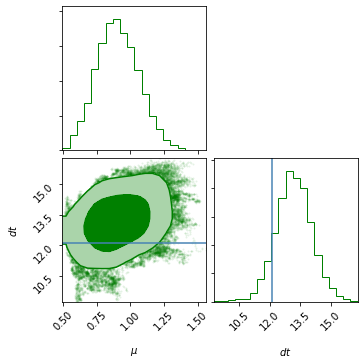

In [57]:
contour(fit4)

Again $\mu$ is away off. But interestingly the time delay is constrained well in all the above cases.